In [116]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/PlantVillage/",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
tf.Tensor([1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 2 1 0 0], shape=(32,), dtype=int32)
[1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 2 1 0 0]


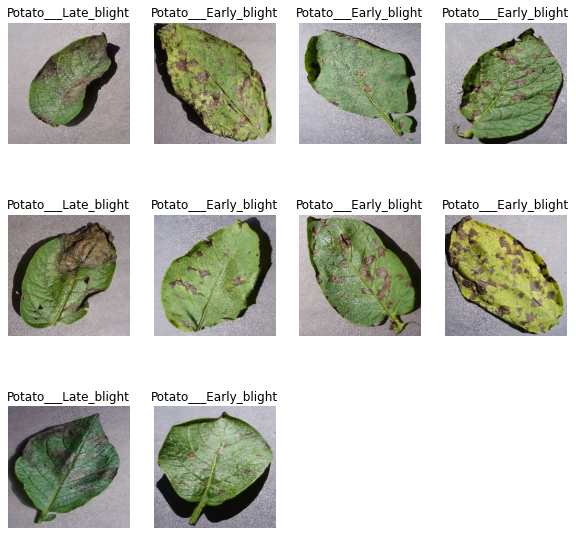

In [19]:

for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(3,4, i + 1)
        plt.axis("off")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
    print(image_batch.shape)
    print(label_batch)
    print(label_batch.numpy())

### 20% testing = 10% validation = 10% testing

In [20]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=10000):
    
    if shuffle_size != -1: 
        ds = ds.shuffle(shuffle_size, seed=12)
    ds_len = len(ds)
    print(f"ds_len {ds_len}")
    train_size = int(ds_len * train_split)
    print(f"train_size {train_size}")
    train_ds = ds.take(train_size)
    print(f"train_ds {len(train_ds)}")
    
    test_ds = ds.skip(train_size)
    print(f"test_ds original {len(test_ds)}")
    # divide by 2 to get 10% of validaiton and 10% for testing
    half = int(len(test_ds) / 2)
    val_ds = test_ds.take(half)
    test_ds = test_ds.skip(half)
    print(f"val_ds {len(val_ds)}")
    print(f"test_ds {len(test_ds)}")
    
    return (train_ds, val_ds, test_ds)

(train_ds, val_ds, test_ds) = split_dataset(dataset)

ds_len 68
train_size 54
train_ds 54
test_ds original 14
val_ds 7
test_ds 7


### Store in cache as it improves the pipeline because we don't have to access the disc and just store the image in memory

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds  = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [98]:
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
def get_model():
    image_preprocessing = tf.keras.Sequential([
        # we resize so that when we later supply an image, it gets automatically resized to 256,256
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),  
        layers.experimental.preprocessing.Rescaling(1./255),
    ])
    # data_augmentation = tf.keras.Sequential([
    #     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #     layers.experimental.preprocessing.RandomRotation(0.2, input_shape=(256,256,3)),
    # ])
    model = tf.keras.Sequential([
        image_preprocessing,
        # data_augmentation,
        layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=input_shape ),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPool2D((2,2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    return model

In [99]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [100]:
with tf.device('/GPU:0'):
    model = get_model()

In [101]:
    model.build(input_shape=input_shape)

In [102]:
    model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_31 (Sequential)   (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (32, 256, 256, 32)        896       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (32, 128, 128, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (32, 128, 128, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (32, 64, 64, 64)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (32, 64, 64, 64)          36928     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (32, 32, 32, 64)        

In [103]:
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy']
    )

In [104]:
    history = model.fit(train_ds, epochs = 50, batch_size = BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/50


2022-03-14 01:20:24.555534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.9139 - accuracy: 0.4786

2022-03-14 01:20:36.970169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 13s 236ms/step - loss: 0.9139 - accuracy: 0.4786 - val_loss: 0.8597 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 12s 220ms/step - loss: 0.6617 - accuracy: 0.7541 - val_loss: 0.5723 - val_accuracy: 0.7634
Epoch 3/50
54/54 [==============================] - 11s 211ms/step - loss: 0.4587 - accuracy: 0.8281 - val_loss: 0.4309 - val_accuracy: 0.8527
Epoch 4/50
54/54 [==============================] - 11s 211ms/step - loss: 0.3534 - accuracy: 0.8709 - val_loss: 0.2298 - val_accuracy: 0.9196
Epoch 5/50
54/54 [==============================] - 12s 225ms/step - loss: 0.2156 - accuracy: 0.9259 - val_loss: 0.1708 - val_accuracy: 0.9554
Epoch 6/50
54/54 [==============================] - 11s 212ms/step - loss: 0.1733 - accuracy: 0.9358 - val_loss: 0.3278 - val_accuracy: 0.8839
Epoch 7/50
54/54 [==============================] - 11s 211ms/step - loss: 0.1789 - accuracy: 0.9410 - val_loss: 0.1278 - val_accuracy: 0.9643
Epoch 8/50

In [168]:
    model.evaluate(val_ds)

7/7 [==============================] - 1s 75ms/step - loss: 0.1631 - accuracy: 0.9821


[0.16313692927360535, 0.9821429252624512]

In [220]:
    image_batch, label_batch = test_ds.as_numpy_iterator().next()
    prediction = model.predict_on_batch(image_batch)


2022-03-14 02:32:39.097499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [221]:
prediction = [np.argmax(item) for item in prediction]

In [222]:
print(len(prediction))


32


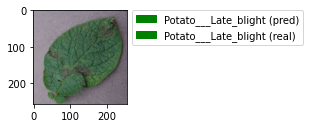

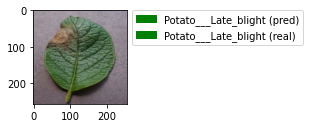

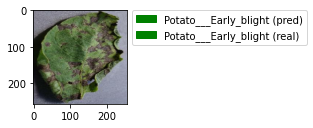

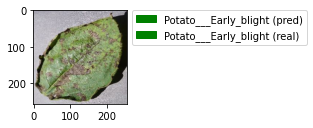

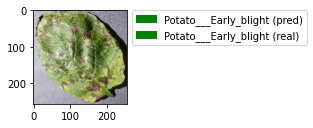

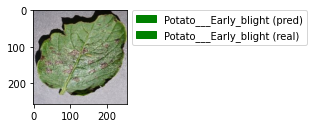

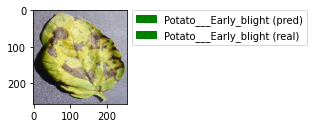

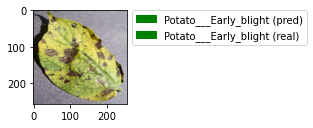

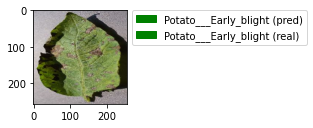

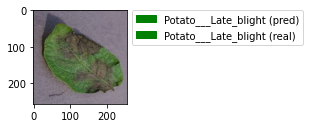

In [234]:
import matplotlib.patches as mpatches
for i in range(10):
    plt.figure(figsize=(15,10))
    plt.axis("off")
    plt.subplot(5,2, i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    equal = class_names[prediction[i]] == class_names[label_batch[i]]

    color1 = 'green'
    if not equal:
        color1 = 'red'

    pred_label = mpatches.Patch(color=color1, label=f"{class_names[prediction[i]]} (pred)")
    real_label = mpatches.Patch(color='green', label=f"{class_names[label_batch[i]]} (real)")
    patches = [pred_label, real_label]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

In [235]:
prediction = model.predict(test_ds)

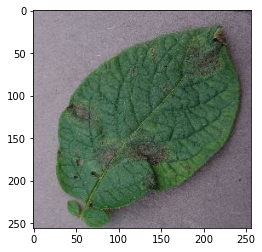

In [246]:
for image_batch, label_batch in test_ds.take(1).as_numpy_iterator():
    plt.imshow(image_batch[0].astype('uint8'))

### When we change somethmodel_version = 1ing in the model, don't forget to change the version

In [279]:
model_version = 1

### Find the latest version and increment

In [281]:
import os
models = list(filter(lambda x: 'model' in x, os.listdir(".")))

if len(models) > 0:   
    model_version = int(models[-1].split('-')[-1])
    print(f"dirs: {os.listdir('.')}")
    print(f"models: {models}")
    print(f"version: {model_version}")
    model_version = model_version + 1
    print(f"new version: {model_version}")

dirs: ['model-version-1', '.DS_Store', 'images', 'training.ipynb', '.ipynb_checkpoints', '.git']
models: ['model-version-1']
version: 1
new version: 2


In [282]:
model.save(f"model-version-{model_version}")

INFO:tensorflow:Assets written to: model-version-2/assets
